# Comparing Classifiers using Parkinson Sound Recording Dataset

In this project, the Parkinson Sound recording dataset from the UCI Machine Learning
Repository [1] is used to compare the performance of different classifiers. This dataset includes
the features extracted from the sound recordings of 20 Parkinson’s Disease (PD) patients and
20 healthy individuals. It aims to identify PD patients through their verbal ability. Therefore,
the class column contains binary values where 0 (Class B) represents a healthy person and 1
(Class A) represents a PD patient. Originally, there are two datasets for training and testing
respectively. The first text document, train_data.txt was used since it had enough data points
for the activity. There are 1040 data points in this dataset of which, the first 790 data were used
for training and the remaining 250 were used for testing. All attributes are numeric.

In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns # used to plot the confusion matrix


In [2]:
# Shuffle the Input Data:
def shuffle_data(input_data, input_data_name): 
    data = pd.read_csv(input_data, header=None)
    data = data.fillna(0)
    data = data.values
    randomized_data = np.random.permutation(data)
    name = input_data_name + '.csv'
    np.savetxt(name, randomized_data, delimiter=",")
    return data

## Classifiers

K-Nearest Neighbors, AdaBoost, and Naïve Bayes Classifiers were selected to compare their
performance on the numeric data. Before classification, Principal Component Analysis (PCA)
is applied to the training data to select the attributes with the highest significance to the
classification results. Based on visual inspection, the first 17 features were kept since the
eigenvalues for those features are significantly large. Then, the three classifiers are applied
respectively

For K-Nearest Neighbors, cross-validation is performed to select parameter K. 20
folds were used to save on computation time since reasonable results were received at this
value. In this process, the number of neighbors was incrementally increased by 1 from 2 to 201.
From this computation, the classifier achieves the highest accuracy with K=6. Therefore, it is
selected for the actual classification. The overall results are presented as follows.

In [3]:
def knn_cv_optimization(x_train, y_train):
    parameter = 2
    error = []
    optimum_parameter = 1
    folds = 20
    for i in range(200):
        knn = KNeighborsClassifier(n_neighbors=parameter)
        scores = cross_val_score(knn, x_train, y_train, cv=folds)
        error.append(scores.mean())

        if scores.mean() == min(error):
            optimum_parameter  = parameter 
        parameter += 1

    return optimum_parameter

In [4]:
def knn_classifier(x_train,y_train,x_test, cv_parameter):
    # Training
    start_time = time.time()
    optimum_knn = KNeighborsClassifier(n_neighbors=cv_parameter)
    optimum_knn.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time

    # Testing
    start_time = time.time()
    y_predicted = optimum_knn.predict(x_test)
    end_time = time.time()

    testing_time = end_time - start_time

    score = optimum_knn.predict_proba(x_test)[::,1]
    
    return training_time, testing_time, y_predicted, score

In [5]:
# AdaBoost Classifier
def ada_classifier(x_train, y_train, x_test):
    # Training
    start_time = time.time()
    ada = AdaBoostClassifier()
    ada.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time

    # Testing
    start_time = time.time()
    y_predicted = ada.predict(x_test)
    end_time = time.time()

    testing_time = end_time - start_time

    score = ada.predict_proba(x_test)[::,1]

    return training_time, testing_time, y_predicted, score

In [6]:
# Naive Bayes Classifier
def nb_classifier(x_train, y_train, x_test):
    # Training
    start_time = time.time()
    NB = GaussianNB()
    NB.fit(x_train,y_train)
    end_time = time.time()
    
    training_time = end_time - start_time

    # Testing
    start_time = time.time()
    y_predicted = NB.predict(x_test)
    end_time = time.time()
    
    testing_time = end_time - start_time
    
    score = NB.predict_proba(x_test)[::,1]
    return training_time, testing_time, y_predicted, score

## Confusion Matrix

In [7]:
def confusion_matrix_plot(classifier, actual_results, predicted_results):
    matrix = confusion_matrix(actual_results, predicted_results, labels=[1.0, 0.0])
    TP, FN, FP, TN = confusion_matrix(actual_results, predicted_results, labels=[1.0, 0.0]).ravel()

    TPR = round((TP / (TP + FN)) * 100, 1)  # True positive rate
    TNR = round((TN / (TN + FP)) * 100, 1)  # True negative rate
    PPV = round((TP / (TP + FP)) * 100,
                1)  # precision or positive prediction value
    NPV = round((TN / (TN + FN)) * 100, 1)  # Negative prediction value
    FPR = round((FP / (FP + TN)) * 100, 1)  # False positive rate
    FNR = round((FN / (TP + FN)) * 100, 1)  # False negative rate
    FDR = round((FP / (TP + FP)) * 100, 1)  # False discovery rate
    accuracy = round(((TP + TN) / (TP + FP + FN + TN)) * 100, 1)  # how often is the classifier right
    # Note: Values above converted to percentages

    rates_matrix = [[TPR, FNR], [FPR, TNR]]  # results of the confusion matrix as percetages of the statistical rates
    statistical_matrix = [[TPR, FNR], [TNR, FPR]]  # results of the confusion matrix arranged as TPR and FPR

    # Heatmap plot
    # Results of the confusion matrix

    plt.rc('font', size=20)  # controls default text size
    plt.rc('axes', titlesize=20)  # fontsize of the title
    plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)  # fontsize of the x tick labels
    plt.rc('ytick', labelsize=20)  # fontsize of the y tick labels
    plt.rc('legend', fontsize=20)  # fontsize of the legend

    # Heatmap plot i.e. Results of the confusion matrix
    plot1 = plt.figure()  # first plot showing confusion matrix observations
    g1 = sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g', square=True)
    g1.set_title(classifier+' Confusion Matrix')
    g1.set_xlabel('Predicted Values')
    g1.set_ylabel('Actual Values')

    g1.xaxis.set_ticklabels(['1', '0'])
    g1.yaxis.set_ticklabels(['1', '0'])
    # Plotting the statistical results of the confusion matrix
    plot2 = plt.figure()
   
    g2 = sns.heatmap(rates_matrix, annot=True, cmap='Blues', fmt='g', square=True) # second plot showing confusion matrix results as percentages
    for t in g2.texts: t.set_text(
        t.get_text() + " %")  # adding a percentage symbol to the plot by iterating over the results
    g2.xaxis.set_ticklabels(['1', '0'])
    g2.yaxis.set_ticklabels(['1', '0'])
    g2.set_title(classifier+' Confusion Matrix as Percentages')
    g2.set_xlabel('Predicted Values')
    g2.set_ylabel('Actual Values')

## Result

In [8]:
# Plot the Results of Each Classifier:
def results(classifier_name, training_time, testing_time, y_predicted, y_test, score):
    print('----- {} -----'.format(classifier_name))
    print("Training Run Time:", '%.6f' % training_time)
    print("Testing Run Time:", '%.6f' % testing_time)
    print("Total Computation Time:", '%.6f' % (training_time+testing_time))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    
    # Confusion Matrix
    matrix = confusion_matrix(y_test, y_predicted,labels=[1.0, 0.0])
    print("Confusion Matrix:\n", matrix)
    confusion_matrix_plot(classifier_name, y_test,y_predicted)
    
    # ROC Curve
    plt.figure()
    fpr, tpr, _ = roc_curve(y_test, score)
    plt.plot(fpr, tpr)
    plt.title(classifier_name + ' ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print("")


----- KNN Classifier -----
Training Run Time: 0.002002
Testing Run Time: 0.138633
Total Computation Time: 0.140635
Accuracy: 0.608
Confusion Matrix:
 [[90 48]
 [50 62]]

----- AdaBoost Classifier -----
Training Run Time: 0.296352
Testing Run Time: 0.009643
Total Computation Time: 0.305995
Accuracy: 0.62
Confusion Matrix:
 [[87 51]
 [44 68]]

----- Naive Bayes Classifier -----
Training Run Time: 0.009634
Testing Run Time: 0.000998
Total Computation Time: 0.010632
Accuracy: 0.648
Confusion Matrix:
 [[104  34]
 [ 54  58]]



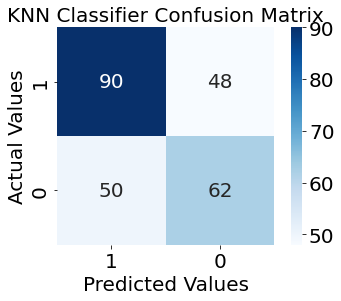

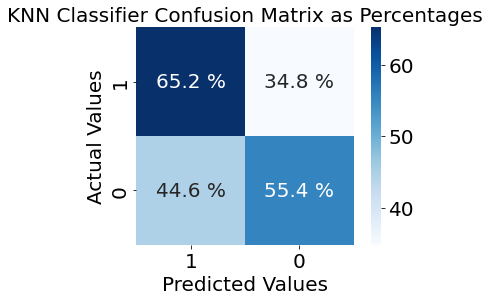

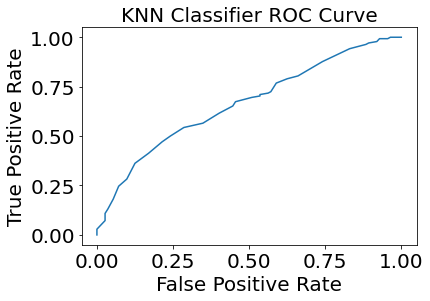

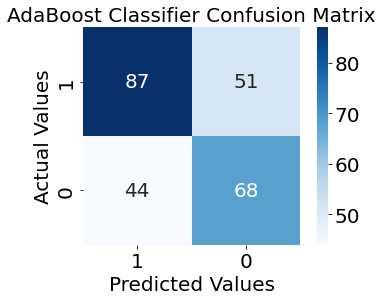

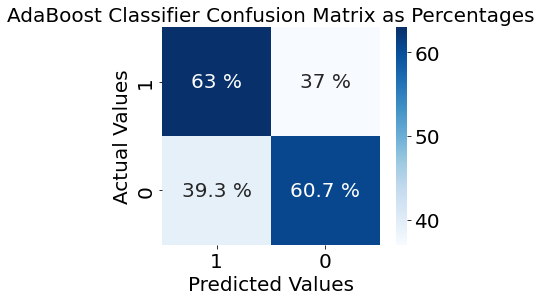

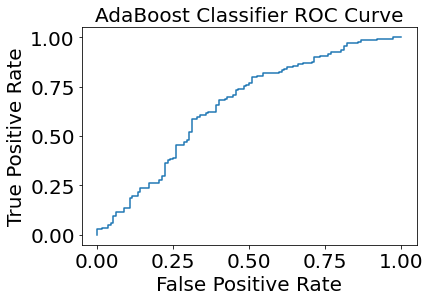

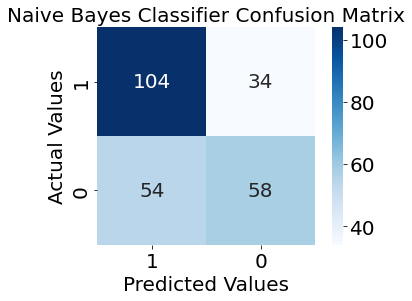

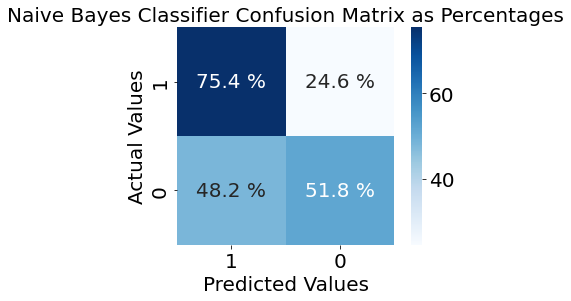

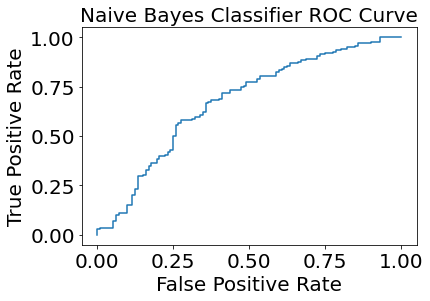

In [10]:
def main():
    # shuffle data if first time. Changed to False since already completed.
    shuffle = False
    if shuffle == True:
        shuffle_data('train_data.txt','data')

    # Import the data
    data = pd.read_csv("data.csv",header=None)
    data = data.fillna(0)
    data = data.values
    x = data[:,1:-2]
    x = np.array(x,dtype=float)

    # Split Data into Training and Testing Class:
    split = 790 #split the data for training and testing (790 for training and the remainder for testing)

    # Principal Component Analysis
    x_mean = np.mean(x)
    x_mc = x - x_mean
    x_cov = np.dot(x_mc.T, x_mc)
    D, E = np.linalg.eig(x_cov)

    # Sorting the eigenvectors and eigenvalues
    sorted_index = np.argsort(D)
    sorted_D = D[sorted_index]
    sorted_E = np.zeros(E.shape)

    index = 0
    for i in range(25,-1,-1):
        sorted_E[:, index] = E[:, sorted_index[i]]
        index = index + 1

    y = np.dot(x_mc, sorted_E)  # principal component outputs i.e. all principal component scores

    # Based on visual inspection, we shall keep features the first 17 features since
    # the eigenvalues are significantly large for those features.

    reduced_E = sorted_E[:, 0:17]  # reduced eigenvectors
    reduced_y = y[:, 0:17]  # reduced principal component outputs

    x_train = reduced_y[:split, :]
    x_test = reduced_y[split:, :]

    # Split Labels into Training and Testing Classes:
    xc = data[:,-1:]
    xc = np.array(xc,dtype=float).ravel()
    xc_train =data[:split,-1:]
    xc_test = data[split:,-1:]
    xc_train = np.array(xc_train,dtype=float).ravel()
    xc_test = np.array(xc_test,dtype=float).ravel()

    # Perform Classification:
    optimum_parameter = knn_cv_optimization(x_train, xc_train)
    knn_training_time, knn_testing_time, knn_predicted, knn_score = knn_classifier(x_train, xc_train, x_test, optimum_parameter)
    ada_training_time, ada_testing_time, ada_predicted, ada_score = ada_classifier(x_train, xc_train,x_test)
    nb_training_time, nb_testing_time, nb_predicted, nb_score = nb_classifier(x_train, xc_train, x_test)

    # Show the Results:
    results('KNN Classifier', knn_training_time, knn_testing_time, knn_predicted, xc_test, knn_score)
    results('AdaBoost Classifier', ada_training_time, ada_testing_time, ada_predicted, xc_test, ada_score)
    results('Naive Bayes Classifier', nb_training_time, nb_testing_time, nb_predicted, xc_test, nb_score)

    plt.show()
if __name__ == "__main__":
    main()

## Experiment Results and Conclusions

We can see that AdaBoost, the classifier with the longest computation time has
the lowest accuracy out of the three classifiers. Naïve Bayes with the shortest computation time
has comparable accuracy as K-Nearest Neighbors which has the highest accuracy. To further
understand the performance of the three classifiers, confusion matrices and ROC curves are
computed, and results summarized below.

1. Confusion Matrix

From the figures, we observed that the Naïve Bayes classifier has the highest percentage
in True Positives, whereas the K-Nearest Neighbour classifier has the highest percentage in
True Negatives. It is also worth mentioning that while the Naïve Bayes classifier performs the
best in the positive class, it has the lowest percentage in True Negatives among the three
classifiers.

2. ROC Curve

Among the three ROC curves, the one from K-Nearest Neighbors is smoother than the
remaining curves. Nevertheless, from observation, all three curves have a similar area under
the curve, which is close to 50% of the graphs. This indicates that the distributions of the two
classes are highly overlapped, which could be one of the reasons resulting in poor performance
in classification.

#### References


[1] “UCI Machine Learning Repository: Parkinson Speech Dataset with Multiple Types of
Sound Recordings Data Set.”
http://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types
+of+Sound+Recordings (accessed Apr. 25, 2022).